In [1]:
import random
import numpy as np

random.seed(42)
np.random.seed(42)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

import pymdp
from pymdp import utils

In [2]:
def get_most_probable_indices(qs):
    return [np.argmax(q) for q in qs]

In [3]:
def get_max_prob_index(prob_array):
    return int(np.argmax(prob_array))

In [4]:
def step_print(produzione1, produzione2, produzione3, segnale1, segnale2, segnale3, vendite1, vendite2, vendite3, magazzino1, magazzino2, magazzino3, ware_levels):
    print(f"Produzione 1: {produzione1}, Produzione 2: {produzione2}, Produzione 3: {produzione3}")
    print(f"Segnale analisi 1: {segnale1}, Segnale analisi 2: {segnale2}, Segnale analisi 3: {segnale3}")
    print(f"Vendite 1: {vendite1}, Vendite 2: {vendite2}, Vendite 3: {vendite3}")
    print(f"Magazzino 1: {magazzino1, ware_levels[0]}, Magazzino 2: {magazzino2, ware_levels[1]}, Magazzino 3: {magazzino3, ware_levels[2]}")
    print("--------------------------------------------------")

In [5]:
def return_level(warehouses,pf_lev, ic_lev, oc_lev):
    levels = [""] * len(warehouses)
    for i,j in enumerate(warehouses):
        if j < pf_lev:
            levels[i] = "perfect"
        elif pf_lev-1 < j < ic_lev:
            levels[i] = "in control"
        elif j > oc_lev:
            levels[i] = "out of control"
        else:
            levels[i] = "loading"
    return levels

In [6]:
def revenue(market_price, sales): 
    C_gain = (market_price)*sales 
    return C_gain

In [7]:
from river.preprocessing import StandardScaler
from river.drift import ADWIN
from river.ensemble import SRPRegressor
from river.tree import HoeffdingTreeRegressor

SRP_1 = (StandardScaler() |
        SRPRegressor(
            n_models=10,
            seed=1,
            drift_detector=ADWIN(delta=0.001),
            warning_detector=ADWIN(delta=0.01),
            model = HoeffdingTreeRegressor(
                grace_period=50,
                leaf_prediction='adaptive',
                model_selector_decay=0.9,                
            )            
        ))

SRP_2 = (StandardScaler() |
        SRPRegressor(
            n_models=10,
            seed=1,
            drift_detector=ADWIN(delta=0.001),
            warning_detector=ADWIN(delta=0.01),
            model = HoeffdingTreeRegressor(
                grace_period=50,
                leaf_prediction='adaptive',
                model_selector_decay=0.9,               
            )            
        ))

SRP_3 = (StandardScaler() |
        SRPRegressor(
            n_models=10,
            seed=1,
            drift_detector=ADWIN(delta=0.001),
            warning_detector=ADWIN(delta=0.01),
            model = HoeffdingTreeRegressor(
                grace_period=50,
                leaf_prediction='adaptive',
                model_selector_decay=0.9,               
            )            
        ))

In [8]:
def revenue_SRP(SRP_model, my_sales, sales_competitor1, sales_competitor2):
    gains = []
    for prod in my_sales:
        # Create a feature dictionary for each instance.
        # Adjust the key names according to your feature naming.
        instance = {
            'prod_1': prod,
            'prod_2': sales_competitor1,
            'prod_3': sales_competitor2
        }
        # Predict the market price for this instance.
        predicted_price = SRP_model.predict_one(instance)
        # Compute the gain for this production level.
        c_gain = (predicted_price) * prod 
        gains.append(c_gain)
    return np.array(gains)

In [9]:
def build_transition_matrix(preferred_sales, state_warehouse, action_production, size_warehouse, std_dev=1.0):
    """
    Costruisce la matrice di transizione B[s', s, a] che assegna una probabilità
    a ogni stato successivo s' dato uno stato s e un'azione a.
    
    Parameters:
    - preferred_sales: int, il livello di magazzino desiderato
    - state_warehouse: list o array degli stati del magazzino
    - action_production: list o array delle azioni di produzione
    - size_warehouse: int, dimensione massima del magazzino
    - std_dev: float, deviazione standard del rumore nella transizione
    
    Returns:
    - B: ndarray tridimensionale (s', s, a)
    """
    B = np.zeros((len(state_warehouse), len(state_warehouse), len(action_production)))

    for s in range(len(state_warehouse)):
        for a in range(len(action_production)):
            mu = s + a - preferred_sales
            mu = np.clip(mu, 0, size_warehouse - 1)

            for s_prime in range(len(state_warehouse)):
                prob = norm.pdf(s_prime, loc=mu, scale=std_dev)
                B[s_prime, s, a] = prob

            # Normalizzazione per avere distribuzione di probabilità
            B[:, s, a] /= B[:, s, a].sum()

    return B


# States, Observations and Actions

## States

In [10]:
max_warehouse = 10
size_warehouse = max_warehouse + 1
max_production = 6
n_action = max_production + 1

# states
state_warehouse = np.arange(0, size_warehouse)
state_context = ['OK production', 'Reduce production']
state_epistemic = ['Epistemic', 'Non-epistemic']


# number of states
n_states = [len(state_warehouse), len(state_context), len(state_epistemic)]

# number of factors
n_factors = len(n_states)

## Actions

In [11]:
# production 
action_production = np.arange(0, n_action)
action_context = ['DN']
action_analysis = ['Do nothing', 'Ware analysis']

# number of actions
n_controls = [len(action_production), len(action_analysis)]

## Observations

In [12]:
# my items sold
obs_sales = np.arange(0, size_warehouse)
obs_last_production = np.arange(0, n_action)
obs_level_ware = ["perfect", "in control", "loading", "out of control"]
obs_analysis = ["Null", "Analysis"]

num_obs = [len(obs_sales), len(obs_last_production), len(obs_level_ware), len(obs_analysis)]
num_modalities = len(num_obs)

## BR dynamics

In [13]:
# when dealing with 3 players defining a proper framework can be difficult
def compute_desired_cost(BR1, BR2, BR3, max_customer_price, sensibility):
    """
    Compute cost_prod_1, cost_prod_2, cost_prod_3 such that the
    given BR1, BR2, BR3 satisfy:
      BR_i = (max_customer_price - 4*c_i + c_j + c_k) / (4*sensibility)

    Returns (cost_prod_1, cost_prod_2, cost_prod_3).
    """
    a = max_customer_price
    b = sensibility

    cost_prod_1 = a/2 - b*(6*BR1 + 2*BR2 + 2*BR3)/5
    cost_prod_2 = a/2 - b*(2*BR1 + 6*BR2 + 2*BR3)/5
    cost_prod_3 = a/2 - b*(2*BR1 + 2*BR2 + 6*BR3)/5

    return cost_prod_1, cost_prod_2, cost_prod_3


In [14]:
assumed_market_price_1 = 30
assumed_market_price_2 = 30
assumed_market_price_3 = 30

max_customer_price = 30
sensibility = 1

cost_prod = compute_desired_cost(BR1=5, BR2=4, BR3=3, 
                                 max_customer_price=max_customer_price, 
                                 sensibility=sensibility)

print(f"Computed costs: {cost_prod}")

cost_prod_1, cost_prod_2, cost_prod_3 = cost_prod

# (3pl) BR_i = (a-4*c_i + sum(c_{-i}))/(4*b)
BR_1 = (max_customer_price - 4 * cost_prod_1 + cost_prod_2 + cost_prod_3) / (4*sensibility)
BR_2 = (max_customer_price - 4 * cost_prod_2 + cost_prod_3 + cost_prod_1) / (4*sensibility)
BR_3 = (max_customer_price - 4 * cost_prod_3 + cost_prod_1 + cost_prod_2) / (4*sensibility)
BR_1_idx = round(BR_1)
BR_2_idx = round(BR_2)
BR_3_idx = round(BR_3)
print(f'Best response for industry 1: {BR_1}')
print(f'Best response for industry 2: {BR_2}')
print(f'Best response for industry 3: {BR_3}')

Computed costs: (6.199999999999999, 7.0, 7.8)
Best response for industry 1: 5.000000000000001
Best response for industry 2: 4.0
Best response for industry 3: 3.0


# Likelihood matrices

In [15]:
A1 = utils.obj_array(num_modalities)
A2 = utils.obj_array(num_modalities)
A3 = utils.obj_array(num_modalities)

## A[sales]

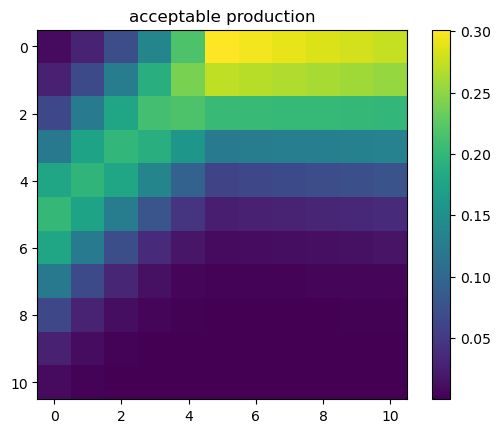

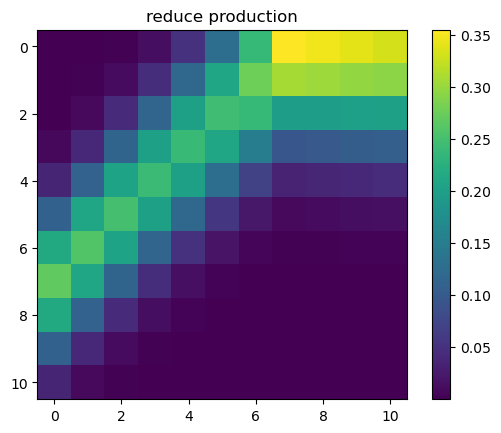

In [16]:
A1_sales = np.zeros((len(obs_sales),len(state_warehouse), len(state_context), len(state_epistemic)))
A2_sales = np.zeros((len(obs_sales),len(state_warehouse), len(state_context), len(state_epistemic)))
A3_sales = np.zeros((len(obs_sales),len(state_warehouse), len(state_context), len(state_epistemic)))

for i, state in enumerate(state_context):

    if state == 'OK production':
        soglia = 5  # soglia dopo la quale la media resta fissa
        base_std = 2  # deviazione standard iniziale
        std_growth = 0.05  # crescita della deviazione standard dopo la soglia
    else:
        soglia = 7  # soglia dopo la quale la media resta fissa
        base_std = 1.5  # deviazione standard iniziale
        std_growth = 0.05  # crescita della deviazione standard dopo la soglia

    for idx, epist in enumerate(state_epistemic):

        for j, n in enumerate(state_warehouse):

            mu = max(0, soglia-n)
            sigma = base_std + std_growth * n  # decresce con n

            # Calcolo la distribuzione normale per ogni valore di vendita osservata
            A1_sales[:, j, i, idx] = norm.pdf(obs_sales, loc=mu, scale=sigma)

            # Normalizzo la colonna per renderla una distribuzione di probabilità
            A1_sales[:, j, i, idx] /= A1_sales[:, j, i, idx].sum()


A1[0] = A1_sales
A2[0] = A1_sales
A3[0] = A1_sales

matrix = A1_sales[:,:,0,0]
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("acceptable production")
plt.show()

matrix = A1_sales[:,:,1,0]
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title("reduce production")
plt.show()

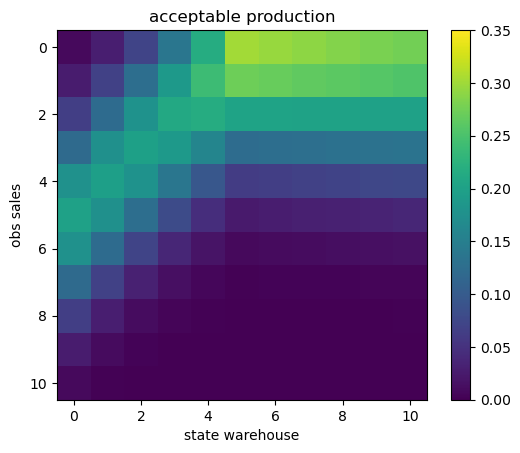

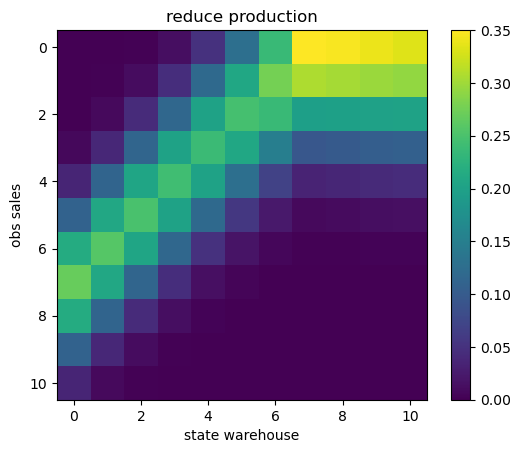

In [17]:
# Common color scale limits
vmin = 0.0
vmax = 0.35

# First plot: acceptable production
matrix = A1_sales[:, :, 0, 0]
plt.imshow(matrix, cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.ylabel("obs sales")
plt.xlabel("state warehouse")
plt.title("acceptable production")
plt.show()

# Second plot: reduce production
matrix = A1_sales[:, :, 1, 0]
plt.imshow(matrix, cmap='viridis', interpolation='nearest', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.ylabel("obs sales")
plt.xlabel("state warehouse")
plt.title("reduce production")
plt.show()

## A[last action]

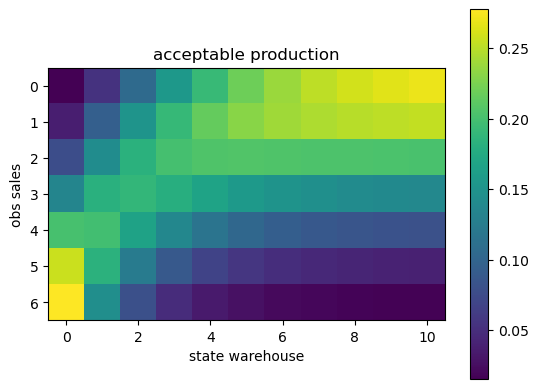

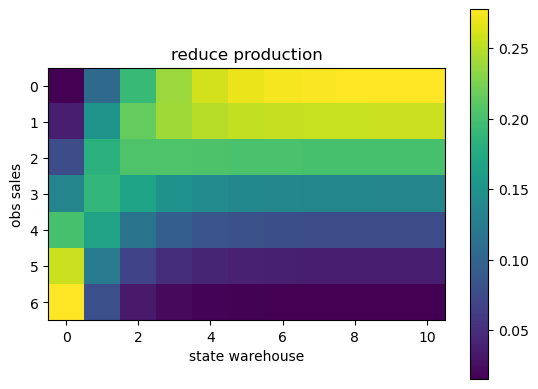

In [18]:
A1_production = np.zeros((len(obs_last_production),len(state_warehouse), len(state_context), len(state_epistemic)))
#A2_production = np.zeros((len(obs_last_production),len(state_warehouse), len(state_context), len(state_epistemic)))



for i, state in enumerate(state_context):

    if state == 'OK production':
        max_prod = n_action - 1
        base_std = 2.5  # deviazione standard
        reverse_strength = 4.0  # quanto velocemente la media scende
    else:
        max_prod = n_action - 1
        base_std = 2.5  # deviazione standard
        reverse_strength = 8.0  # quanto velocemente la media scende

    for idx, epist in enumerate(state_epistemic):
        
        for j, n in enumerate(state_warehouse):
            # La media della produzione cala linearmente col magazzino
            mu = max_prod * np.exp(-reverse_strength * n / state_warehouse[-1])
            sigma = base_std

            A1_production[:, j, i, idx] = norm.pdf(obs_last_production, loc=mu, scale=sigma)
            A1_production[:, j, i, idx] /= A1_production[:, j, i, idx].sum()


A1[1] = A1_production
A2[1] = A1_production
A3[1] = A1_production

matrix = A1_production[:,:,0,1]
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.ylabel("obs sales")
plt.xlabel("state warehouse")
plt.title("acceptable production")
plt.show()

matrix = A1_production[:,:,1,1]
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.ylabel("obs sales")
plt.xlabel("state warehouse")
plt.title("reduce production")
plt.show()

## A[level_ware]

In [19]:
pf_level = 3
ic_level = 5
oc_level = 8

In [20]:
import numpy as np
import pymdp.utils as utils


# inizializzo la matrice full A1_ware
n_obs    = len(obs_level_ware)
n_ware   = len(state_warehouse)
n_ctx    = len(state_context)
n_epist  = len(state_epistemic)

A1_ware = np.zeros((n_obs, n_ware, n_ctx, n_epist))

# ricreo prima la vecchia matrice base senza contesto
A_base = np.zeros((n_obs, n_ware, n_epist))

for idx_e, epist in enumerate(state_epistemic):
    if epist == "Epistemic":
        # caso deterministico
        for j, level in enumerate(obs_level_ware):
            if level == "perfect":
                A_base[j, :pf_level, idx_e] = 1
            elif level == "in control":
                A_base[j, pf_level:ic_level, idx_e] = 1
            elif level == "loading":
                A_base[j, ic_level:oc_level, idx_e] = 1
            elif level == "out of control":
                A_base[j, oc_level:, idx_e] = 1
    else:
        # caso "noisy" basato su slice Epistemic
        noise_std = 0.4
        base = A_base[:, :, state_epistemic.index("Epistemic")]

        for w in range(n_ware):
            col_base = base[:, w]
            centers = np.where(col_base > 0)[0]
            if len(centers) == 0:
                A_base[:, w, idx_e] = 1.0 / n_obs
            else:
                noisy_col = np.zeros(n_obs)
                for c0 in centers:
                    distances = np.abs(np.arange(n_obs) - c0)
                    gaussian = np.exp(-(distances**2) / (2 * noise_std**2))
                    noisy_col += gaussian
                noisy_col = np.clip(noisy_col, 0, None)
                noisy_col /= noisy_col.sum()
                A_base[:, w, idx_e] = noisy_col

# definisco i pesi P(context | osservazione)
#    riga = osservazione, colonna = contesto
context_weights = np.array([
    [0.99, 0.01],  # perfect
    [0.80, 0.20],  # in control
    [0.20, 0.80],  # loading
    [0.01, 0.99],  # out of control
])  # shape = (n_obs, n_ctx)

# espando A_base su dimensione contesto e rinormalizzo
for e in range(n_epist):
    for w in range(n_ware):
        base_col = A_base[:, w, e]
        for c in range(n_ctx):
            raw = base_col * context_weights[:, c]
            if raw.sum() == 0:
                # fallback (se per qualche colonna tutti zeri)
                raw = base_col.copy()
            A1_ware[:, w, c, e] = raw / raw.sum()

# assegno alle matrici pymdp
A1[2] = A1_ware
A2[2] = A1_ware
A3[2] = A1_ware

# verifica
assert utils.is_normalized(A1_ware), "A1_ware NON è normalizzata!"


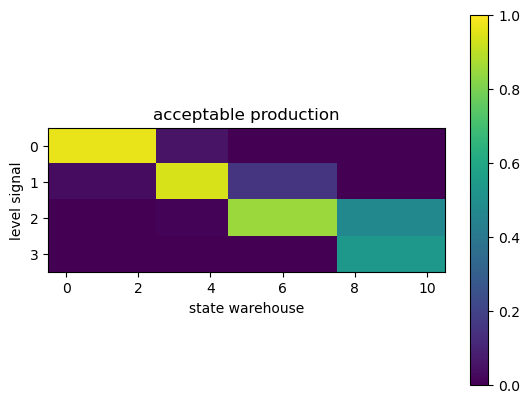

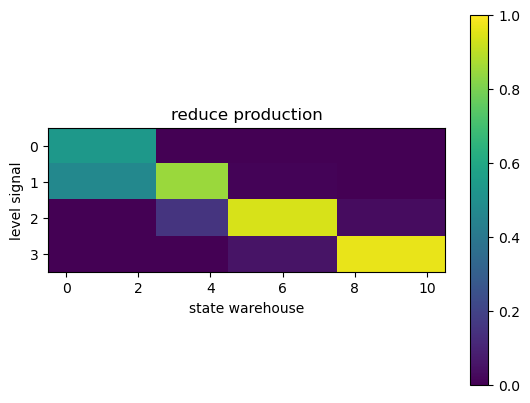

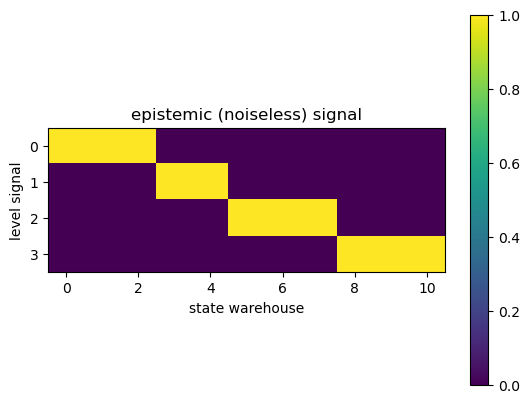

In [21]:
matrix = A1_ware[:,:,0,1]
plt.imshow(matrix, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.ylabel("level signal")
plt.xlabel("state warehouse")
plt.title("acceptable production")
#plt.title("Produzione OK - Segnale rumoroso")
plt.show()

matrix = A1_ware[:,:,1,1]
plt.imshow(matrix, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.ylabel("level signal")
plt.xlabel("state warehouse")
plt.title("reduce production")
# plt.title("Riduzione della produzione - Segnale rumoroso")
plt.show()

matrix = A1_ware[:,:,0,0]
plt.imshow(matrix, cmap='viridis', interpolation='nearest', vmin=0, vmax=1)
plt.colorbar()
plt.ylabel("level signal")
plt.xlabel("state warehouse")
plt.title("epistemic (noiseless) signal")
plt.show()

## A[analysis]

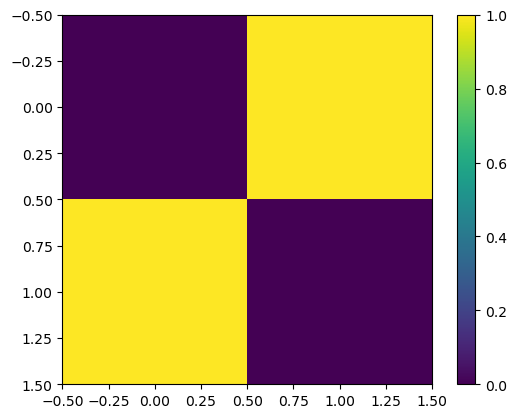

In [22]:
A1_analysis = np.zeros((len(obs_analysis),len(state_warehouse),len(state_context),len(state_epistemic)))
#A2_analysis = np.zeros((len(obs_analysis),len(state_warehouse),len(state_context),len(state_epistemic)))

for j, state in enumerate(state_context):
    for i, ware in enumerate(state_warehouse):
        A1_analysis[1,i,j,0] = 1
        A1_analysis[0,i,j,1] = 1

A1[3] = A1_analysis
A2[3] = A1_analysis
A3[3] = A1_analysis

matrix = A1_analysis[:,6,1,:]
plt.imshow(matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

# Transition probabilities matrices

In [23]:
B1 = utils.obj_array(n_factors)
B2 = utils.obj_array(n_factors)
B3 = utils.obj_array(n_factors) 

## B[warehouse]

In [24]:
B_warehouse1 = np.zeros((len(state_warehouse), len(state_warehouse), len(action_production)))

preferred_sales = BR_1_idx  # vogliamo andare verso s-2
# Parametro di rumore
std_dev = 1.0  # deviazione standard del rumore

for s in range(len(state_warehouse)):  # Stato iniziale
    for a in range(len(action_production)):  # Azione di produzione

        # Centro della distribuzione = stato + produzione - 2
        mu = s + a - preferred_sales
        mu = np.clip(mu, 0, size_warehouse - 1)

        for s_prime in range(len(state_warehouse)):
            prob = norm.pdf(s_prime, loc=mu, scale=std_dev)
            B_warehouse1[s_prime, s, a] = prob

        # Normalizza la colonna per renderla una distribuzione di probabilità
        B_warehouse1[:, s, a] /= B_warehouse1[:, s, a].sum()

In [25]:
B_warehouse2 = np.zeros((len(state_warehouse), len(state_warehouse), len(action_production)))

preferred_sales = BR_2_idx  # vogliamo andare verso s-2
# Parametro di rumore
std_dev = 1.0  # deviazione standard del rumore

for s in range(len(state_warehouse)):  # Stato iniziale
    for a in range(len(action_production)):  # Azione di produzione

        # Centro della distribuzione = stato + produzione - 2
        mu = s + a - preferred_sales
        mu = np.clip(mu, 0, size_warehouse - 1)

        for s_prime in range(len(state_warehouse)):
            prob = norm.pdf(s_prime, loc=mu, scale=std_dev)
            B_warehouse2[s_prime, s, a] = prob

        # Normalizza la colonna per renderla una distribuzione di probabilità
        B_warehouse2[:, s, a] /= B_warehouse2[:, s, a].sum()

In [26]:
B_warehouse3 = np.zeros((len(state_warehouse), len(state_warehouse), len(action_production)))

preferred_sales = BR_3_idx  # vogliamo andare verso s-2
# Parametro di rumore
std_dev = 1.0  # deviazione standard del rumore

for s in range(len(state_warehouse)):  # Stato iniziale
    for a in range(len(action_production)):  # Azione di produzione

        # Centro della distribuzione = stato + produzione - 2
        mu = s + a - preferred_sales
        mu = np.clip(mu, 0, size_warehouse - 1)

        for s_prime in range(len(state_warehouse)):
            prob = norm.pdf(s_prime, loc=mu, scale=std_dev)
            B_warehouse3[s_prime, s, a] = prob

        # Normalizza la colonna per renderla una distribuzione di probabilità
        B_warehouse3[:, s, a] /= B_warehouse3[:, s, a].sum()

In [27]:
B1[0] = B_warehouse1
B2[0] = B_warehouse2
B3[0] = B_warehouse3

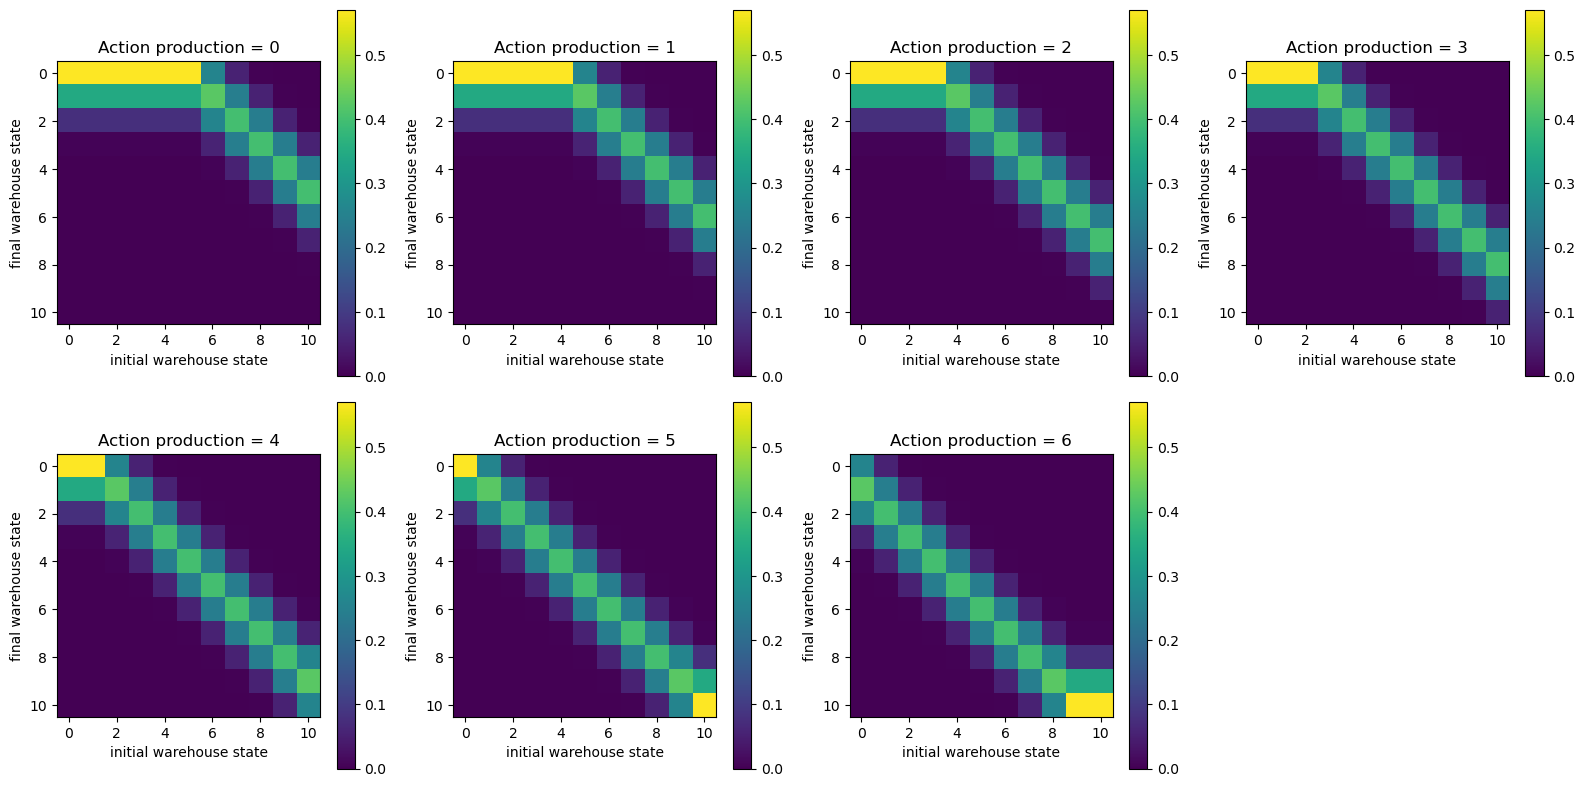

In [28]:
# Determina il numero di righe e colonne per i subplot
matrix = B_warehouse1
n_actions = matrix.shape[2]
n_cols = 4 #int(np.ceil(np.sqrt(n_actions)))
n_rows = 2 #int(np.ceil(n_actions / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

# Appiattiamo gli assi per iterare facilmente (funziona anche se la griglia non è quadrata)
axes = axes.flatten()

for i in range(n_actions):
    im = axes[i].imshow(matrix[:, :, i], cmap='viridis', interpolation='nearest')
    axes[i].set_title(f'Action production = {i}')
    axes[i].set_xlabel('initial warehouse state')
    axes[i].set_ylabel('final warehouse state')
    fig.colorbar(im, ax=axes[i])

# Nasconde eventuali subplot vuoti
for j in range(n_actions, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## B[context]

In [29]:
B_context = np.zeros((len(state_context), len(state_context), len(action_context)))

p_correct = 0.5 # probabilità che si rimanga nel contesto precedente

for a in range(len(action_context)):
    for s in range(len(state_context)):
        for s_prime in range(len(state_context)):
            if s_prime == s:
                B_context[s_prime, s, a] = p_correct
            else:                    
                B_context[s_prime, s, a] = (1 - p_correct) / (len(state_context) - 1)
        # Normalizza ogni colonna
    B_context[:, :, a] /= B_context[:, :, a].sum(axis=0)

B1[1] = B_context
B2[1] = B_context
B3[1] = B_context

## B[state]

In [30]:
B_epistemic = np.zeros((len(state_epistemic), len(state_epistemic), len(action_analysis)))

for i, a in enumerate(action_analysis):
    if a == 'Ware analysis':
        B_epistemic[0,:,i] = 1
    else:
        B_epistemic[1,:,i] = 1 

B1[2] = B_epistemic
B2[2] = B_epistemic
B3[2] = B_epistemic

# Goal prior

In [31]:
C1 = utils.obj_array_zeros(num_obs)
C2 = utils.obj_array_zeros(num_obs)
C3 = utils.obj_array_zeros(num_obs)

## C[sales]

In [32]:
C_sales_1 = revenue(market_price=assumed_market_price_1, sales=obs_sales)
C_sales_2 = revenue(market_price=assumed_market_price_2, sales=obs_sales)
C_sales_3 = revenue(market_price=assumed_market_price_3, sales=obs_sales)

C1[0] = C_sales_1
C2[0] = C_sales_2
C3[0] = C_sales_3

## C[production]

In [33]:
C_production_1 = -cost_prod_1 * action_production
C_production_2 = -cost_prod_2 * action_production
C_production_3 = -cost_prod_3 * action_production

C1[1] = C_production_1
C2[1] = C_production_2
C3[1] = C_production_3

## C[ware]
Se supero una certa soglia magari devo sostenere dei costi di gestione maggiori, se la situazione è critica dei costi di smaltimento.

In [34]:
C_ware = np.array([0, -15, -75, -100])

C1[2] = C_ware
C2[2] = C_ware
C3[2] = C_ware

## C[analysis]

In [35]:
C_analysis = np.array([0, -3.5])

C1[3] = C_analysis
C2[3] = C_analysis
C3[3] = C_analysis

# State Prior

In [36]:
D1 = utils.obj_array(n_factors)
D2 = utils.obj_array(n_factors)
D3 = utils.obj_array(n_factors)

D_warehouse = utils.onehot(0, len(state_warehouse))
D_context = utils.onehot(0, len(state_context))
D_epistemic = utils.onehot(1, len(state_epistemic))

D1[0] = D_warehouse
D2[0] = D_warehouse
D3[0] = D_warehouse

D1[1] = D_context
D2[1] = D_context
D3[1] = D_context

D1[2] = D_epistemic
D2[2] = D_epistemic
D3[2] = D_epistemic


# Agent initialization

In [37]:
B1_prior = utils.dirichlet_like(B1)
B2_prior = utils.dirichlet_like(B2)
B3_prior = utils.dirichlet_like(B3)

In [38]:
from pymdp.agent import Agent

In [39]:
my_agent1 = Agent(A = A1, B = B1, C = C1, D = D1, policy_len=3,
                  use_states_info_gain = False,
                  use_param_info_gain = True,
                  scale_state=0.1)

In [40]:
my_agent2 = Agent(A = A2, B = B2, C = C2, D = D2, policy_len=3,
                  use_states_info_gain = False,
                  use_param_info_gain = True,
                  scale_state=0.1)

In [41]:
my_agent3 = Agent(A = A3, B = B3, C = C3, D = D3, policy_len=3,
                  use_states_info_gain = False,
                  use_param_info_gain = True,
                  scale_state=0.1)

# Environment

In [42]:
class CournotMarket(object):

    def __init__(self, 
                 reputation=(1/3, 1/3, 1/3), 
                 total_demand=5, 
                 max_customer_price=10, 
                 sensibility=1, 
                 warehouse_1=0, 
                 warehouse_2=0, 
                 warehouse_3=0):
        # --- Validate and normalize reputation vector ---
        if not hasattr(reputation, "__iter__") or len(reputation) != 3:
            raise ValueError("reputation must be a sequence of three numeric values (e.g. [0.3, 0.4, 0.3]).")

        reputation = [float(r) for r in reputation]
        total_rep = sum(reputation)

        if total_rep <= 0:
            raise ValueError("Reputation values must be positive and sum to a positive number.")

        # Automatically normalize to sum to 1
        reputation = [r / total_rep for r in reputation]
        self.reputation = tuple(reputation)

        # --- Store other parameters ---
        self.total_demand = float(total_demand)
        self.max_customer_price = float(max_customer_price)
        self.sensibility = float(sensibility)
        self.warehouse_1 = int(warehouse_1)
        self.warehouse_2 = int(warehouse_2)
        self.warehouse_3 = int(warehouse_3)
    

    def step(self, action1, action2, action3, time_step):
        # --- (Optional dynamic demand logic)
        if time_step == 6:
            self.total_demand = 12
        if time_step == 11: 
            self.total_demand = 9
        if time_step == 15:
            self.total_demand = 20
            self.max_customer_price = 45

        real_total_demand = self.total_demand
        print(f"Real total demand: {real_total_demand}")
        
        # --- Compute total available products per firm ---
        total_product = [
            action1[0] + self.warehouse_1,
            action2[0] + self.warehouse_2,
            action3[0] + self.warehouse_3
        ]
        product_availability = sum(total_product)

        # --- Market price adjustment based on total availability ---
        market_price = max(0, self.max_customer_price - self.sensibility * product_availability)

        # --- Preferred demand allocation (based on reputation) ---
        preferred_demand = [int(real_total_demand * r) for r in self.reputation]
        remainder = int(real_total_demand - sum(preferred_demand))
        if remainder > 0:
            # distribute remainder randomly or to the most reputed firm
            preferred_demand[preferred_demand.index(max(preferred_demand))] += remainder

        # --- Actual sales limited by availability ---
        actual_sales = [min(total_product[i], preferred_demand[i]) for i in range(3)]

        # --- Remaining unsatisfied demand per firm ---
        remaining_demand = [preferred_demand[i] - actual_sales[i] for i in range(3)]

        # --- Redistribution of unmet demand to firms with remaining stock ---
        for i in range(3):
            if remaining_demand[i] > 0:
                # Find firms with spare stock
                for j in range(3):
                    if j != i and total_product[j] > actual_sales[j]:
                        extra_sales = min(total_product[j] - actual_sales[j], remaining_demand[i])
                        actual_sales[j] += extra_sales
                        remaining_demand[i] -= extra_sales
                        if remaining_demand[i] <= 0:
                            break

        # --- Update warehouses ---
        new_warehouses = [total_product[i] - actual_sales[i] for i in range(3)]
        self.warehouse_1, self.warehouse_2, self.warehouse_3 = new_warehouses

        # --- Record analyses ---
        analyses = []
        for action in [action1, action2, action3]:
            analyses.append("Analysis" if len(action) > 2 and action[2] == 1 else "Null")

        # --- Prepare observations ---
        obs_sales = [int(s) for s in actual_sales]
        obs_last_prod = [int(action1[0]), int(action2[0]), int(action3[0])]
        h_obs_warehouse = [int(w) for w in new_warehouses]
        obs_level_ware = return_level(h_obs_warehouse, pf_level, ic_level, oc_level)
        obs_analysis = analyses

        return obs_sales, market_price, obs_last_prod, obs_level_ware, obs_analysis, h_obs_warehouse

# Active Inference Loop

In [43]:
prod1 = []
prod2 = []
prod3 = []
warehouse1 = [0]
warehouse2 = [0]
warehouse3 = [0]
sold1 = []
sold2 = []
sold3 = []

infer_ware1 = []
infer_ware2 = []
infer_ware3 = []

infer_context1 = []
infer_context2 = []
infer_context3 = []

epistemic_choice1 = []
epistemic_choice2 = []
epistemic_choisce3 = []

real_price =[]
predicted_price1 = []
predicted_price2 = []
predicted_price3 = []

Belief_gain1 =[]
real_gain1 = []

Belief_gain2 =[]    
real_gain2 = []

Belief_gain3 =[]    
real_gain3 = []

Max_price = []

In [44]:
def run_active_inference_loop(my_agent1, my_agent2, my_agent3, my_env, size_warehouse, T=5):
    """Runs an active inference loop where alpha increases over time."""

    market_price = assumed_market_price_1
    size_ware = size_warehouse
    size_warehouse = np.arange(size_warehouse)
    obs1 = [0, 0, obs_level_ware.index("perfect"), obs_analysis.index("Null")] 
    obs2 = [0, 0, obs_level_ware.index("perfect"), obs_analysis.index("Null")]
    obs3 = [0, 0, obs_level_ware.index("perfect"), obs_analysis.index("Null")]

    starting_sales_states = [0, 0, 0]
    obs_last_sales = starting_sales_states

    # starting_sales_states = [0, 0, 0]
    # obs_last_sales = starting_sales_states

    null_instance = {f"prod_{i}": v for i, v in enumerate(obs_last_sales)}

    SRP_1.learn_one(null_instance, market_price)
    SRP_2.learn_one(null_instance, market_price)
    SRP_3.learn_one(null_instance, market_price)

    old_max_price_1 = SRP_1.predict_one(null_instance) 
    old_max_price_2 = SRP_2.predict_one(null_instance) 
    old_max_price_3 = SRP_3.predict_one(null_instance)


    for t in range(T):
        qs_ware1, qs_ctx1, qs_epist1 = my_agent1.infer_states(obs1)
        qs_ware2, qs_ctx2, qs_epist2 = my_agent2.infer_states(obs2)
        qs_ware3, qs_ctx3, qs_epist3 = my_agent3.infer_states(obs3)
        print("supposed warehouse 1:", get_max_prob_index(qs_ware1))
        print("context 1:", get_max_prob_index(qs_ctx1))
        print("analisi 1:", get_max_prob_index(qs_epist1))
        print("supposed warehouse 2:", get_max_prob_index(qs_ware2))
        print("context 2:", get_max_prob_index(qs_ctx2))
        print("analisi 2:", get_max_prob_index(qs_epist2))
        print("supposed warehouse 3:", get_max_prob_index(qs_ware3))
        print("context 3:", get_max_prob_index(qs_ctx3))
        print("analisi 3:", get_max_prob_index(qs_epist3))
        
        # Update preference distribution (C matrix) using a custom revenue function
        print(obs_last_sales)
        my_agent1.C[0] = revenue_SRP(SRP_1, my_sales=size_warehouse, sales_competitor1=obs_last_sales[1], sales_competitor2=obs_last_sales[2])
        my_agent2.C[0] = revenue_SRP(SRP_2, my_sales=size_warehouse, sales_competitor1=obs_last_sales[0], sales_competitor2=obs_last_sales[2])
        my_agent3.C[0] = revenue_SRP(SRP_3, my_sales=size_warehouse, sales_competitor1=obs_last_sales[0], sales_competitor2=obs_last_sales[1])
        

        # Infer policies
        q_pi_1, efe_1 = my_agent1.infer_policies()
        q_pi_2, efe_2 = my_agent2.infer_policies()
        q_pi_3, efe_3 = my_agent3.infer_policies()

        # Sample actions based on stochastic policy selection
        action_1 = my_agent1.sample_action()
        action_2 = my_agent2.sample_action()
        action_3 = my_agent3.sample_action()
        
        # Environment step
        obs_sales, market_price, obs_last_prod, obs_level, obs_analysis_signal, h_obs_warehouse = my_env.step(action_1, action_2, action_3, t)

        step_print(produzione1=obs_last_prod[0], produzione2=obs_last_prod[1], produzione3=obs_last_prod[2],
                   segnale1=obs_analysis_signal[0], segnale2=obs_analysis_signal[1], segnale3=obs_analysis_signal[2],
                   vendite1=obs_sales[0], vendite2=obs_sales[1], vendite3=obs_sales[2],
                   magazzino1=h_obs_warehouse[0], magazzino2=h_obs_warehouse[1], magazzino3=h_obs_warehouse[2],
                   ware_levels=obs_level)

        instance = {f"prod_{i}": v for i, v in enumerate(obs_sales)}

        price_hat_1 = SRP_1.predict_one(instance)
        price_hat_2 = SRP_2.predict_one(instance)
        price_hat_3 = SRP_3.predict_one(instance)
        SRP_1.learn_one(instance, market_price)
        SRP_2.learn_one(instance, market_price)
        SRP_3.learn_one(instance, market_price)

        #---------- Update B (if needed) ----------------#
        Max_price.append(SRP_1.predict_one(null_instance))
        
        new_max_price_1 = SRP_1.predict_one(null_instance) + 5
        new_max_price_2 = SRP_2.predict_one(null_instance) + 5
        new_max_price_3 = SRP_3.predict_one(null_instance) + 5

        
        print("old max price 1:", old_max_price_1)
        print("new max price 1:", new_max_price_1)
        print("old max price 2:", old_max_price_2)
        print("new max price 2:", new_max_price_2)
        print("old max price 3:", old_max_price_3)
        print("new max price 3:", new_max_price_3)

        # RIPRENDERE DA QUI E MODIFICARE LA LOGICA DI BR!!!
        if (abs(new_max_price_1 - old_max_price_1))/old_max_price_1 > 0.2:
            BR_1 = (new_max_price_1 - 4 * cost_prod_1 + cost_prod_2 + cost_prod_3) / (4*sensibility)
            BR_1_idx = round(min(BR_1, max_production))
            print(f"NEW BR 1: {BR_1_idx}")
            B1_new = build_transition_matrix(preferred_sales=BR_1_idx, state_warehouse=state_warehouse, 
                                             action_production=action_production, size_warehouse=size_ware)
            my_agent1.B[0] = B1_new
        
        if (abs(new_max_price_2 - old_max_price_2))/old_max_price_2 > 0.2:
            BR_2 = (new_max_price_2 - 4 * cost_prod_2 + cost_prod_3 + cost_prod_1) / (4*sensibility)
            BR_2_idx = round(min(BR_2, max_production))
            print(f"NEW BR 2: {BR_2_idx}")
            B2_new = build_transition_matrix(preferred_sales=BR_2_idx, state_warehouse=state_warehouse, 
                                             action_production=action_production, size_warehouse=size_ware)
            my_agent2.B[0] = B2_new
        
        if (abs(new_max_price_3 - old_max_price_3))/old_max_price_3 > 0.2:
            BR_3 = (new_max_price_3 - 4 * cost_prod_2 + cost_prod_3 + cost_prod_1) / (4*sensibility)
            BR_3_idx = round(min(BR_3, max_production))
            print(f"NEW BR 3: {BR_3_idx}")
            B3_new = build_transition_matrix(preferred_sales=BR_3_idx, state_warehouse=state_warehouse, 
                                             action_production=action_production, size_warehouse=size_ware)
            my_agent3.B[0] = B3_new

        old_max_price_1 = new_max_price_1
        old_max_price_2 = new_max_price_2
        old_max_price_3 = new_max_price_3

        #----------- end update section -----------------#

        # Update observations
        obs1 = [obs_sales[0], obs_last_prod[0], obs_level_ware.index(obs_level[0]), 
                obs_analysis.index(obs_analysis_signal[0])]
        obs2 = [obs_sales[1], obs_last_prod[1], obs_level_ware.index(obs_level[1]), 
                obs_analysis.index(obs_analysis_signal[1])]
        obs3 =  [obs_sales[2], obs_last_prod[2], obs_level_ware.index(obs_level[2]), 
                obs_analysis.index(obs_analysis_signal[2])]

        # per il prossimo step di training
        obs_last_sales = obs_sales

        # Plot variables

        # 1) plot about production and sales
        prod1.append(obs_last_prod[0])
        prod2.append(obs_last_prod[1])
        prod3.append(obs_last_prod[2])
        warehouse1.append(h_obs_warehouse[0])
        warehouse2.append(h_obs_warehouse[1])
        warehouse3.append(h_obs_warehouse[2])
        sold1.append(obs_sales[0])
        sold2.append(obs_sales[1])
        sold3.append(obs_sales[2])
        infer_ware1.append(get_max_prob_index(qs_ware1))
        infer_ware2.append(get_max_prob_index(qs_ware2))
        infer_ware3.append(get_max_prob_index(qs_ware3))

        epistemic_choice1.append(get_max_prob_index(qs_epist1))
        epistemic_choice2.append(get_max_prob_index(qs_epist2))
        epistemic_choisce3.append(get_max_prob_index(qs_epist3))

        infer_context1.append(get_max_prob_index(qs_ctx1))
        infer_context2.append(get_max_prob_index(qs_ctx2))
        infer_context3.append(get_max_prob_index(qs_ctx3))

        # 2) plot about price estimation
        real_price.append(market_price)
        predicted_price1.append(price_hat_1)
        predicted_price2.append(price_hat_2)
        predicted_price3.append(price_hat_3)

# Main


In [45]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
reputation_env = (1/3, 1/3, 1/3)
total_demand_env = 20
env = CournotMarket(reputation = reputation_env, total_demand = total_demand_env, 
                    max_customer_price = max_customer_price, sensibility = sensibility)

T = 25

run_active_inference_loop(my_agent1, my_agent2, my_agent3, env, size_warehouse=size_warehouse, T = T)

supposed warehouse 1: 0
context 1: 0
analisi 1: 1
supposed warehouse 2: 0
context 2: 0
analisi 2: 1
supposed warehouse 3: 0
context 3: 0
analisi 3: 1
[0, 0, 0]
Real total demand: 20.0
Produzione 1: 6, Produzione 2: 6, Produzione 3: 5
Segnale analisi 1: Analysis, Segnale analisi 2: Null, Segnale analisi 3: Null
Vendite 1: 6, Vendite 2: 6, Vendite 3: 5
Magazzino 1: (0, 'perfect'), Magazzino 2: (0, 'perfect'), Magazzino 3: (0, 'perfect')
--------------------------------------------------
old max price 1: 30.0
new max price 1: 26.174011733880157
old max price 2: 30.0
new max price 2: 26.174011733880157
old max price 3: 30.0
new max price 3: 26.174011733880157
supposed warehouse 1: 0
context 1: 1
analisi 1: 0
supposed warehouse 2: 1
context 2: 0
analisi 2: 1
supposed warehouse 3: 1
context 3: 0
analisi 3: 1
[6, 6, 5]
Real total demand: 20.0
Produzione 1: 6, Produzione 2: 4, Produzione 3: 3
Segnale analisi 1: Null, Segnale analisi 2: Null, Segnale analisi 3: Null
Vendite 1: 6, Vendite 2: 4, 

# Plot

In [47]:
time = np.arange(T)

In [48]:
infer_ware_plot1 = [x + y for x, y in zip(infer_ware1, prod1)]
infer_ware_plot2 = [x + y for x, y in zip(infer_ware2, prod2)]
infer_ware_plot3 = [x + y for x, y in zip(infer_ware3, prod3)]

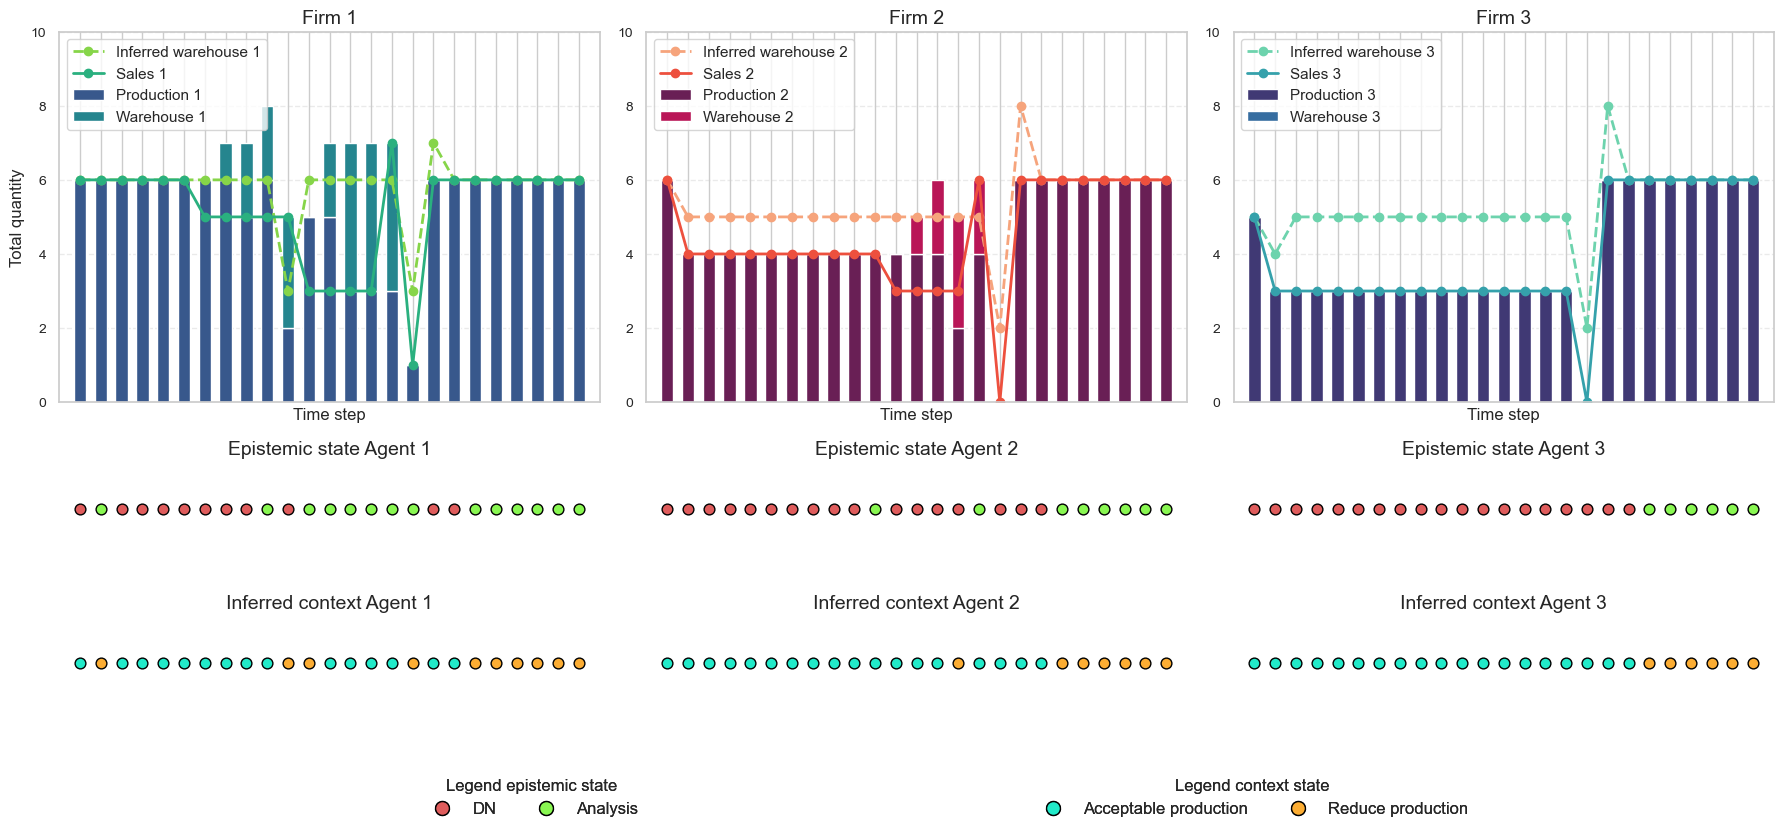

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# --- General Aesthetics ---
sns.set(style="whitegrid")
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

bar_width = 0.6

# --- Elegant color palettes for each firm ---
palette1 = sns.color_palette("viridis", 10)
palette2 = sns.color_palette("rocket", 10)
palette3 = sns.color_palette("mako", 10)

colors_agent1 = {
    'produzione': palette1[2],
    'magazzino': palette1[4],
    'vendite': palette1[6],
    'inferenza': palette1[8]
}
colors_agent2 = {
    'produzione': palette2[2],
    'magazzino': palette2[4],
    'vendite': palette2[6],
    'inferenza': palette2[8]
}
colors_agent3 = {
    'produzione': palette3[2],
    'magazzino': palette3[4],
    'vendite': palette3[6],
    'inferenza': palette3[8]
}

# --- Epistemic and Context Colors ---
color_dn = '#df5c5c'      # red elegant
color_analisi = '#89f752' # green elegant
color_ok = '#21eac9'      # cyan elegant
color_reduce = '#fcad33'  # orange elegant

# --- Layout for 3 firms ---
fig, axs = plt.subplots(3, 3, figsize=(18, 8), gridspec_kw={'height_ratios': [4, 1, 1]}, sharex='col')

# ---------- TOP ROW: Production / Warehouse / Sales ----------
agents_data = [
    (prod1, warehouse1, infer_ware_plot1, sold1, colors_agent1, "Firm 1"),
    (prod2, warehouse2, infer_ware_plot2, sold2, colors_agent2, "Firm 2"),
    (prod3, warehouse3, infer_ware_plot3, sold3, colors_agent3, "Firm 3"),
]

for i, (prod, ware, infer, sold, colors, title) in enumerate(agents_data):
    ax = axs[0, i]
    ax.bar(time, prod, width=bar_width, label=f'Production {i+1}', color=colors['produzione'])
    ax.bar(time, ware[0:T], width=bar_width, bottom=prod, label=f'Warehouse {i+1}', color=colors['magazzino'])
    ax.plot(time, infer, label=f'Inferred warehouse {i+1}', color=colors['inferenza'], marker='o', linestyle='--', linewidth=2)
    ax.plot(time, sold, label=f'Sales {i+1}', color=colors['vendite'], marker='o', linestyle='-', linewidth=2)
    ax.set_title(title)
    ax.set_xlabel('Time step')
    if i == 0:
        ax.set_ylabel('Total quantity')
    ax.legend(loc='upper left', frameon=True)
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    ax.set_xticks(time)
    ax.set_xticklabels(time)
    ax.set_yticks(range(0, 11, 2))
    ax.set_ylim(0, 10)

# ---------- MIDDLE ROW: Epistemic States ----------
epistemic_choices = [epistemic_choice1, epistemic_choice2, epistemic_choisce3]
for i, choices in enumerate(epistemic_choices):
    ax = axs[1, i]
    for t, val in enumerate(choices):
        color = color_dn if val == 1 else color_analisi
        ax.scatter(t, 0, color=color, edgecolor='black', s=60)
    ax.set_xlim(-1, T)
    ax.set_ylim(-1, 1)
    ax.axis('off')
    ax.set_title(f'Epistemic state Agent {i+1}')

# ---------- BOTTOM ROW: Inferred Contexts ----------
infer_contexts = [infer_context1, infer_context2, infer_context3]
for i, contexts in enumerate(infer_contexts):
    ax = axs[2, i]
    for t, val in enumerate(contexts):
        color = color_ok if val == 0 else color_reduce
        ax.scatter(t, 0, color=color, edgecolor='black', s=60)
    ax.set_xlim(-1, T)
    ax.set_ylim(-1, 1)
    ax.axis('off')
    ax.set_title(f'Inferred context Agent {i+1}')

# ---------- Legends ----------
legend_epistemic = [
    Line2D([0], [0], marker='o', color='w', label='DN', markerfacecolor=color_dn, markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Analysis', markerfacecolor=color_analisi, markeredgecolor='black', markersize=10)
]
legend_context = [
    Line2D([0], [0], marker='o', color='w', label='Acceptable production', markerfacecolor=color_ok, markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Reduce production', markerfacecolor=color_reduce, markeredgecolor='black', markersize=10)
]

# --- Add legends below the figure ---
first_legend = fig.legend(handles=legend_epistemic,
                          loc='lower center',
                          ncol=2,
                          frameon=False,
                          fontsize=12,
                          bbox_to_anchor=(0.3, -0.05),
                          title='Legend epistemic state')
second_legend = fig.legend(handles=legend_context,
                           loc='lower center',
                           ncol=2,
                           frameon=False,
                           fontsize=12,
                           bbox_to_anchor=(0.7, -0.05),
                           title='Legend context state')

fig.add_artist(first_legend)
fig.add_artist(second_legend)

plt.tight_layout(rect=[0, 0.08, 1, 1])  # Leave space for legends
plt.show()


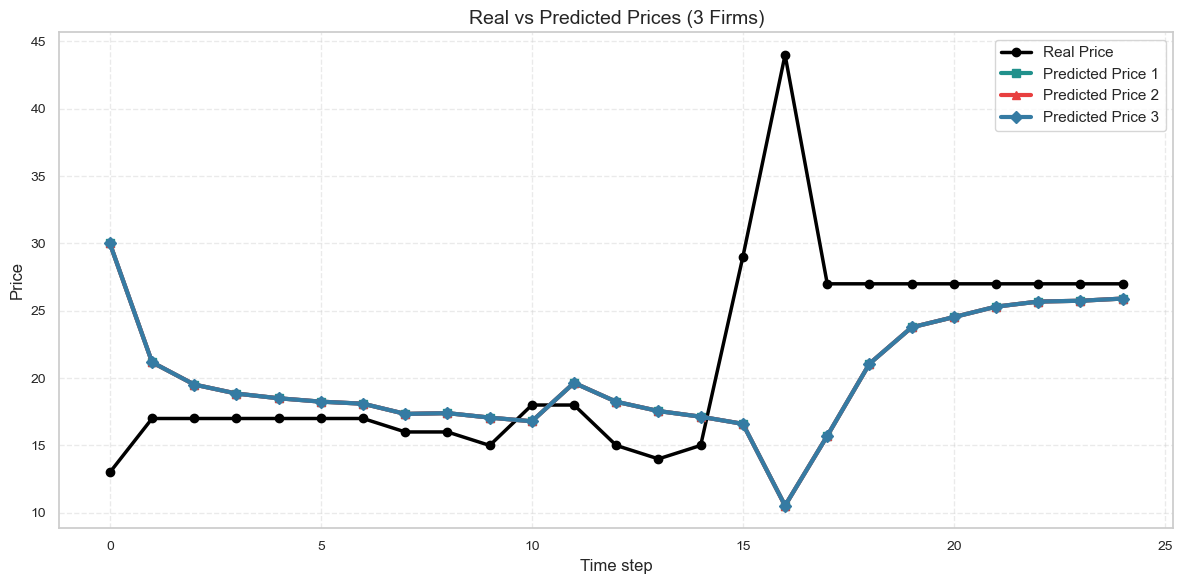

In [50]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# --- Elegant color setup ---
viridis_color = cm.viridis(0.5)            # Firm 1
rocket_color = cm.get_cmap('rocket')(0.6)  # Firm 2
mako_color   = cm.get_cmap('mako')(0.5)    # Firm 3
real_color   = 'black'                     # Ground truth

# Convert to NumPy arrays for safety
predicted_price1_ = np.array(predicted_price1)
predicted_price2_ = np.array(predicted_price2)
predicted_price3_ = np.array(predicted_price3)
real_price_       = np.array(real_price)

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.plot(time, real_price_, label='Real Price', marker='o', color=real_color, linewidth=2.5)
plt.plot(time, predicted_price1_, label='Predicted Price 1', marker='s', color=viridis_color, linewidth=3)
plt.plot(time, predicted_price2_, label='Predicted Price 2', marker='^', color=rocket_color, linewidth=3)
plt.plot(time, predicted_price3_, label='Predicted Price 3', marker='D', color=mako_color, linewidth=3)

# --- Style ---
plt.xlabel('Time step')
plt.ylabel('Price')
plt.title('Real vs Predicted Prices (3 Firms)')
plt.legend(frameon=True, loc='best')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


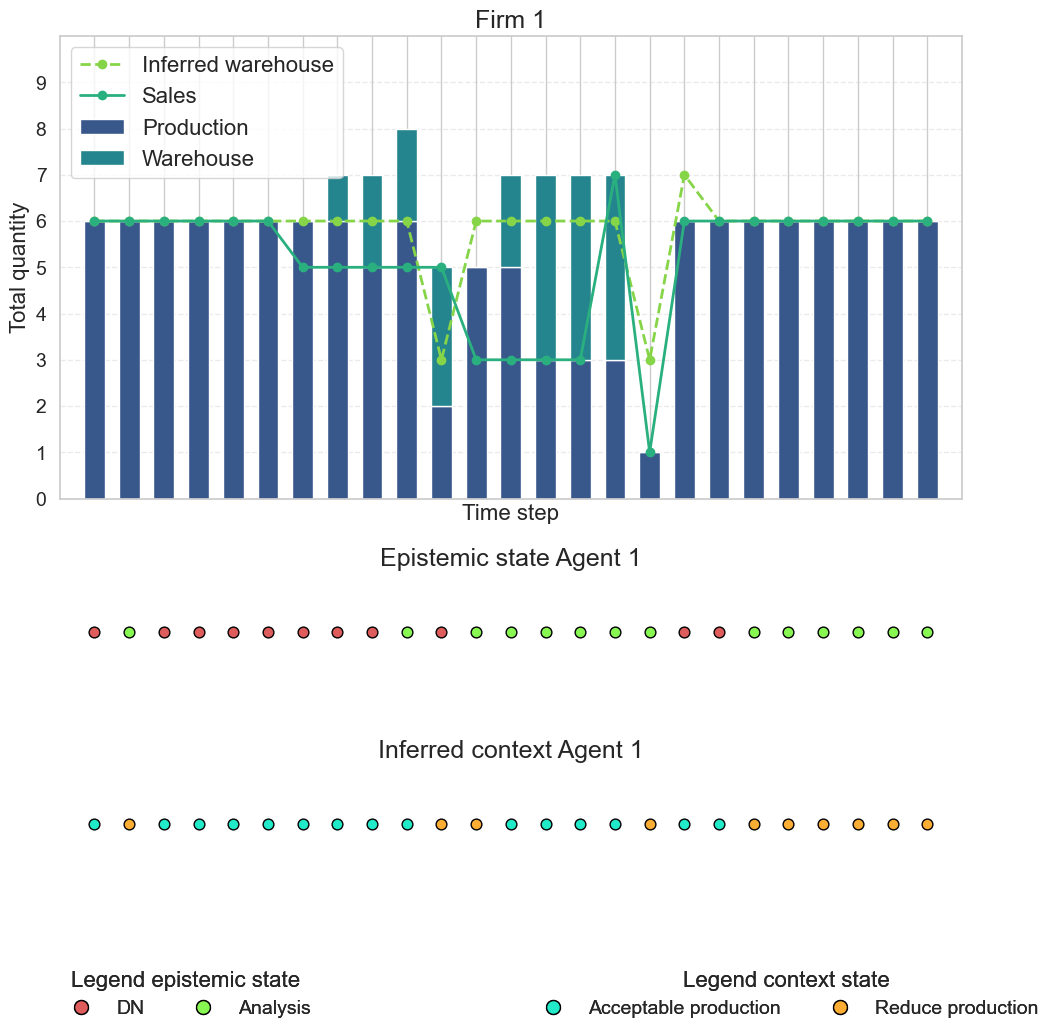

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Setup estetico generale con font leggermente più grande
sns.set(style="whitegrid")
plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14
})

# Asse temporale
bar_width = 0.6

# Palette colori
palette1 = sns.color_palette("viridis", 10)

colors_agent1 = {
    'produzione': palette1[2],
    'magazzino': palette1[4],
    'vendite': palette1[6],
    'inferenza': palette1[8]
}

# Colori epistemici 
color_dn = '#df5c5c'    # rosso elegante
color_analisi = '#89f752'  # verde elegante

# Colori contesto
color_ok = '#21eac9'      # azzurro elegante
color_reduce = '#fcad33'  # arancione elegante

# Layout più alto: 3 righe, 1 colonna, figura più lunga
fig, axs = plt.subplots(3, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [4, 1, 1]}, sharex=True)

# --- Categoria 1 ---
ax1 = axs[0]
ax1.bar(time, prod1, width=bar_width, label='Production', color=colors_agent1['produzione'])
ax1.bar(time, warehouse1[0:T], width=bar_width, bottom=prod1, label='Warehouse', color=colors_agent1['magazzino'])
ax1.plot(time, infer_ware_plot1, label='Inferred warehouse', color=colors_agent1['inferenza'], marker='o', linestyle='--', linewidth=2)
ax1.plot(time, sold1, label='Sales', color=colors_agent1['vendite'], marker='o', linestyle='-', linewidth=2)
ax1.set_title('Firm 1')
ax1.set_ylabel('Total quantity')
ax1.set_xlabel('Time step')
ax1.legend(loc='upper left', frameon=True, fontsize=16)
ax1.grid(axis='y', linestyle='--', alpha=0.4)
ax1.set_xticks(time)
ax1.set_xticklabels(time)
ax1.set_yticks(range(10))
ax1.set_ylim(0, 10)

# --- Stato Epistemico Categoria 1 ---
ax2 = axs[1]
for i, val in enumerate(epistemic_choice1):
    color = color_dn if val == 1 else color_analisi
    ax2.scatter(i, 0, color=color, edgecolor='black', s=60)
ax2.set_xlim(-1, T)
ax2.set_ylim(-1, 1)
ax2.axis('off')
ax2.set_title('Epistemic state Agent 1')

# --- Infer Context Categoria 1 ---
ax3 = axs[2]
for i, val in enumerate(infer_context1):
    color = color_ok if val == 0 else color_reduce
    ax3.scatter(i, 0, color=color, edgecolor='black', s=60)
ax3.set_xlim(-1, T)
ax3.set_ylim(-1, 1)
ax3.axis('off')
ax3.set_title('Inferred context Agent 1')

# --- Legende migliorate ---
legend_epistemic = [
    Line2D([0], [0], marker='o', color='w', label='DN', markerfacecolor=color_dn, markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Analysis', markerfacecolor=color_analisi, markeredgecolor='black', markersize=10)
]

legend_context = [
    Line2D([0], [0], marker='o', color='w', label='Acceptable production', markerfacecolor=color_ok, markeredgecolor='black', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Reduce production', markerfacecolor=color_reduce, markeredgecolor='black', markersize=10)
]

first_legend = fig.legend(handles=legend_epistemic,
                          loc='lower center',
                          ncol=2,
                          frameon=False,
                          title_fontsize=16,
                          fontsize=14,
                          bbox_to_anchor=(0.2, -0.05),
                          title='Legend epistemic state')

second_legend = fig.legend(handles=legend_context,
                           loc='lower center',
                           ncol=2,
                           frameon=False,
                           title_fontsize=16,
                           fontsize=14,
                           bbox_to_anchor=(0.8, -0.05),
                           title='Legend context state')

fig.add_artist(first_legend)
fig.add_artist(second_legend)

# Più spazio per legende in basso
plt.tight_layout(rect=[0, 0.08, 1, 1])
plt.show()
